# **0. Import Library**

Pada kasus ini, diperlukan beberapa library yang menunjang proses, seperti opencv, numpy, seaborn, matplotlib, cvxopt, dan sklearn.

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from cvxopt import matrix, solvers
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# **1. Data Preprocessing**

### **1.1. Set Important Variables**

Definisikan variabel-variabel penting yang akan digunakan dalam proses pelatihan model _machine learning_.

In [2]:
image_size = 128
base_path = "./dataset/"
emotion_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

### **1.2. Load Dataset**

Muat dataset citra yang akan digunakan untuk proses pelatihan model _machine learning_ ke dalam variabel.

In [3]:
data = []
labels = []

for emotion in emotion_names:
    emotion_path = os.path.join(base_path, emotion)
    for image_name in os.listdir(emotion_path):
        image_path = os.path.join(emotion_path, image_name)
        image = cv2.imread(image_path)
        data.append(image)
        labels.append(emotion)

Cek detail dataset dan muat beberapa sampel data untuk ditampilkan.

Number of images: 3500
Number of labels: 3500
Unique labels: {'angry', 'sad', 'surprise', 'neutral', 'fear', 'happy', 'disgust'}
Number of each label: {'angry': np.int64(500), 'disgust': np.int64(500), 'fear': np.int64(500), 'happy': np.int64(500), 'neutral': np.int64(500), 'sad': np.int64(500), 'surprise': np.int64(500)}


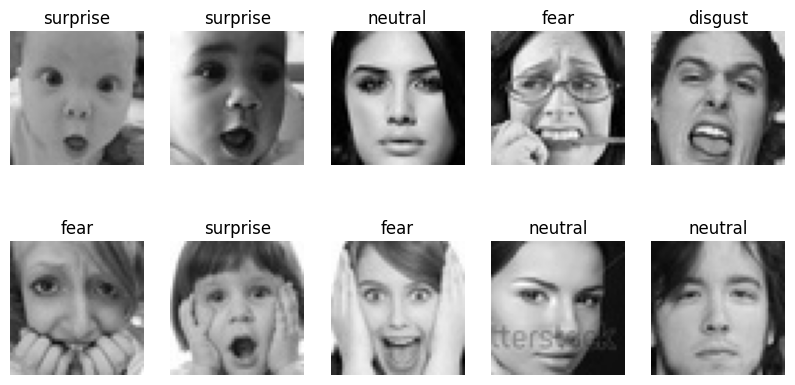

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    index = np.random.randint(0, len(data))
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(data[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis("off")

print(f"Number of images: {len(data)}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {set(labels)}")
print(f"Number of each label: {dict(pd.Series(labels).value_counts())}")

### **1.3. Image Preprocessing**

Definisikan fungsi-fungsi yang digunakan untuk _image preprocessing_ dan rancang _pipeline_ untuk _image preprocessing_.

In [5]:
def convert_to_grayscale(image):
    if len(np.asarray(image).shape) == 2:
        return image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

def resize_image(image, size=None):
    if size is None:
        size = (image_size, image_size)
    if image is None or image.size == 0:
        raise ValueError("Empty or invalid image provided to resize_image")
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return resized_image

def normalize_illumination(image):
    equalized = cv2.equalizeHist(image)
    return equalized

def reduce_noise(image, kernel_size=3):
    denoised = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return denoised

def enhance_features(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 3)
    enhanced = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return enhanced

def preprocess_image(image):
    image = convert_to_grayscale(image)
    image = resize_image(image)
    image = normalize_illumination(image)
    image = reduce_noise(image)
    image = enhance_features(image)
    return image

Proses setiap data berdasarkan _pipeline_ yang dirancang dan konversi menjadi _array numpy_.

In [6]:
for i, image in enumerate(data):
    print(f"Processing image {i + 1}/{len(data)} with label {labels[i]}")
    preprocessed_image = preprocess_image(image)
    data[i] = preprocessed_image
        
data = np.array(data)
labels = np.array(labels)

Processing image 1/3500 with label angry
Processing image 2/3500 with label angry
Processing image 3/3500 with label angry
Processing image 4/3500 with label angry
Processing image 5/3500 with label angry
Processing image 6/3500 with label angry
Processing image 7/3500 with label angry
Processing image 8/3500 with label angry
Processing image 9/3500 with label angry
Processing image 10/3500 with label angry
Processing image 11/3500 with label angry
Processing image 12/3500 with label angry
Processing image 13/3500 with label angry
Processing image 14/3500 with label angry
Processing image 15/3500 with label angry
Processing image 16/3500 with label angry
Processing image 17/3500 with label angry
Processing image 18/3500 with label angry
Processing image 19/3500 with label angry
Processing image 20/3500 with label angry
Processing image 21/3500 with label angry
Processing image 22/3500 with label angry
Processing image 23/3500 with label angry
Processing image 24/3500 with label angry
P

# **2. Feature Extraction**

### **2.1. Canny Edge Detection**

Terapkan deteksi tepi canny dan hitung ciri statistik dari citra yang telah diproses deteksi tepi.

In [7]:
class CannyFeatureExtractor:
    
    # Fungsi konstruktor untuk menginisialisasi parameter deteksi tepi
    def __init__(self, low_threshold=100, high_threshold=200, aperture_size=3, grid_size=(4,4), visualize=False):
        
        # Inisialisasi parameter untuk ekstraksi fitur
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        self.aperture_size = aperture_size
        self.grid_size = grid_size
        self.visualize = visualize

    # Fungsi untuk mendeteksi tepi menggunakan metode Canny
    def detect_edges(self, image):
        
        # Pastikan nilai gambar berada dalam rentang 0-255
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)
            
        # Terapkan deteksi tepi Canny
        edges = cv2.Canny(image, self.low_threshold, self.high_threshold, apertureSize=self.aperture_size)
        return edges
    
    # Fungsi untuk menghitung histogram arah tepi
    def compute_edge_direction_histogram(self, image, edges):
        
        # Kalkulasi gradien menggunakan Sobel
        grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
        
        # Kalkulasi magnitudo dan arah gradien
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        direction = np.arctan2(grad_y, grad_x) % np.pi
        
        # Hanya pertimbangkan arah pada piksel tepi
        edge_directions = direction[edges > 0]
        edge_magnitudes = magnitude[edges > 0]
        
        # Buat histogram dengan 8 bin untuk arah tepi
        hist, _ = np.histogram(edge_directions, bins=8, range=(0, np.pi), weights=edge_magnitudes)
        
        # Normalisasi histogram
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)
            
        return hist
    
    # Fungsi untuk mengekstrak fitur dari gambar menggunakan grid
    def extract_grid_features(self, image, edges):
        
        # Kalkulasi dimensi setiap sel
        height, width = edges.shape
        rows, cols = self.grid_size
        cell_height = height // rows
        cell_width = width // cols
        
        # Inisialisasi list untuk menyimpan fitur
        features = []
        
        # Loop melalui setiap sel dalam grid
        for i in range(rows):
            for j in range(cols):
                
                # Dapatkan koordinat sel
                y_start = i * cell_height
                y_end = min((i + 1) * cell_height, height)
                x_start = j * cell_width
                x_end = min((j + 1) * cell_width, width)
                
                # Ekstrak sel dari citra dan tepi
                cell_image = image[y_start:y_end, x_start:x_end]
                cell_edges = edges[y_start:y_end, x_start:x_end]
                
                # Kalkulasi ciri statistik dasar dari sel
                edge_density = np.sum(cell_edges > 0) / cell_edges.size
                edge_directions = self.compute_edge_direction_histogram(cell_image, cell_edges)
                
                if np.any(cell_edges > 0):
                    # Hitung piksel dalam setiap komponen
                    num_labels, labels = cv2.connectedComponents(cell_edges)
                    component_sizes = [np.sum(labels == i) for i in range(1, num_labels)]
                    if component_sizes:
                        avg_edge_length = np.mean(component_sizes)
                        max_edge_length = np.max(component_sizes)
                        num_edges = len(component_sizes)
                    else:
                        avg_edge_length = 0
                        max_edge_length = 0
                        num_edges = 0
                else:
                    avg_edge_length = 0
                    max_edge_length = 0
                    num_edges = 0
                    
                # Tambahkan seluruh fitur ke list
                cell_features = [edge_density, avg_edge_length, max_edge_length, num_edges]
                cell_features.extend(edge_directions)
                features.extend(cell_features)
        
        return np.array(features)
    
    # Fungsi untuk mengekstrak fitur dari gambar
    def extract_features(self, image):
        
        # Panggil fungsi deteksi tepi dan ekstraksi fitur grid
        edges = self.detect_edges(image)
        features = self.extract_grid_features(image, edges)
        
        # Jika visualize diaktifkan, kembalikan fitur dan tepi
        if self.visualize:
            return features, edges
        return features

### **2.2. Gray Level Co-occurrence Matrix (GLCM)**

Terapkan kuantisasi dan ekstrak matriks kookurensi dari citra, kemudian hitung ciri statistik dari citra yang telah diproses.

In [8]:
class GLCMFeatureExtractor:
    
    # Fungsi konstruktor untuk menginisialisasi parameter GLCM
    def __init__(self, gray_levels=8, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normalized=True):
        
        # Inisialisasi parameter untuk ekstraksi fitur GLCM
        self.gray_levels = gray_levels
        self.distances = distances
        self.angles = angles
        self.symmetric = symmetric
        self.normalized = normalized
    
    # Fungsi untuk mengkuantisasi citra menjadi level abu-abu
    def quantize_image(self, image):
        
        # Inisialisasi minimum dan maksimum nilai piksel
        min_val = np.min(image)
        max_val = np.max(image)
        if max_val == min_val:
            return np.zeros_like(image, dtype=np.int32)
        
        # Kuantisasi citra menjadi level abu-abu
        bins = np.linspace(min_val, max_val, self.gray_levels + 1)
        quantized = np.digitize(image, bins) - 1
        quantized[quantized == self.gray_levels] = self.gray_levels - 1
        return quantized
    
    # Fungsi untuk menghitung GLCM
    def compute_glcm(self, quantized_image):
        
        # Dapatkan dimensi citra
        height, width = quantized_image.shape
        
        # Inisialisasi list untuk menyimpan GLCM
        glcms = []
        
        # Loop melalui setiap jarak dan sudut
        for distance in self.distances:
            for angle in self.angles:
                
                # Inisialisasi GLCM
                glcm = np.zeros((self.gray_levels, self.gray_levels), dtype=np.float32)
                
                # Hitung offset berdasarkan jarak dan sudut
                dx = int(round(distance * np.cos(angle)))
                dy = int(round(distance * np.sin(angle)))
                
                # Iterasi melalui setiap piksel dalam citra
                for i in range(height):
                    for j in range(width):
                        
                        # Dapatkan nilai piksel referensi
                        i_ref = i
                        j_ref = j
                        val_ref = quantized_image[i_ref, j_ref]
                        
                        # Dapatkan nilai piksel tetangga
                        i_nbr = i + dy
                        j_nbr = j + dx
                        
                        # Cek apakah tetangga berada dalam batas
                        if 0 <= i_nbr < height and 0 <= j_nbr < width:
                            val_nbr = quantized_image[i_nbr, j_nbr]
                            glcm[val_ref, val_nbr] += 1
                        
                # Buat simetris jika ditentukan
                if self.symmetric:
                    glcm = glcm + glcm.T
                    
                # Normalisasi jika ditentukan
                if self.normalized:
                    if np.sum(glcm) > 0:
                        glcm = glcm / np.sum(glcm)
                
                # Tambahkan GLCM ke list
                glcms.append(glcm)

        return glcms
    
    # Fungsi untuk menghitung fitur dari GLCM
    def compute_glcm_features(self, glcm):
        
        # Inisialisasi dimensi dan dictionary untuk menyimpan fitur
        features = {}
        rows, cols = np.indices(glcm.shape)
        
        if np.sum(glcm) > 0:
            
            # Hitung Contrast
            features['contrast'] = np.sum(glcm * ((rows - cols) ** 2))
            
            # Hitung Dissimilarity
            features['dissimilarity'] = np.sum(glcm * np.abs(rows - cols))
            
            # Hitung Homogeneity
            features['homogeneity'] = np.sum(glcm / (1 + (rows - cols) ** 2))
            
            # Hitung Energy / Angular Second Moment
            features['energy'] = np.sum(glcm ** 2)
            
            # Hitung Correlation
            mu_i = np.sum(rows * glcm)
            mu_j = np.sum(cols * glcm)
            sigma_i = np.sqrt(np.sum(glcm * (rows - mu_i) ** 2))
            sigma_j = np.sqrt(np.sum(glcm * (cols - mu_j) ** 2))
            if sigma_i > 0 and sigma_j > 0:
                correlation = np.sum(glcm * (rows - mu_i) * (cols - mu_j) / (sigma_i * sigma_j))
                features['correlation'] = correlation
            else:
                features['correlation'] = 0
                
            # Hitung Entropy
            non_zero_glcm = glcm.copy()
            non_zero_glcm[non_zero_glcm == 0] = 1e-10
            features['entropy'] = -np.sum(glcm * np.log2(non_zero_glcm))
            
        else:
            for feature_name in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy']:
                features[feature_name] = 0
        return features
    
    # Fungsi untuk mengekstrak fitur dari citra
    def extract_features(self, image):
        
        # Kuantisasi citra menjadi level abu-abu
        quantized_image = self.quantize_image(image)
        
        # Hitung GLCM
        glcms = self.compute_glcm(quantized_image)
        
        # Hitung nilai fitur untuk setiap GLCM
        all_features = []
        for glcm in glcms:
            features = self.compute_glcm_features(glcm)
            all_features.append(features)
        
        return all_features

### **2.3. Extract Features From Data**

Terapkan ekstraksi fitur Canny dan GLCM pada setiap data untuk memperoleh fitur yang digunakan dalam proses _training_.

In [9]:
canny_feature_extractor = CannyFeatureExtractor()
glcm_feature_extractor = GLCMFeatureExtractor()
features = []

for image in data:
    canny_features = canny_feature_extractor.extract_features(image)
    glcm_features_list = glcm_feature_extractor.extract_features(image)
    glcm_features = []
    for glcm_dict in glcm_features_list:
        glcm_features.extend(list(glcm_dict.values()))
    feature = np.concatenate([canny_features, glcm_features])
    features.append(feature)
            
features = np.array(features)
print("Features shape:", features.shape)

Features shape: (3500, 216)


# **3. Set Up and Train Model**

### **3.1. Support Vector Machine (SVM) Model**

Tahapan ini merupakan tahapan perancangan model _Support Vector Machine_ (SVM) dari _scratch_ dengan tiga jenis kernel (linear, polynomial, rbf) dan optimisasi dengan _solve quadratic problem_.

In [10]:
class SVM:
    
    # Fungsi konstruktor untuk menginisialisasi parameter SVM
    def __init__(self, kernel='rbf', C=10.0, degree=3, gamma=0.01, coef0=0.0):
        self.kernel_type = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.models = {}
        self.is_multiclass = False
        self.kernel = self._get_kernel_function(kernel)
    
    # Fungsi untuk mendapatkan parameter SVM
    def get_params(self, deep=True):
        return {
            "C": self.C,
            "kernel": self.kernel,
            "gamma": self.gamma,
            "degree": self.degree,
            "coef0": self.coef0,
        }

    # Fungsi untuk mengatur parameter SVM
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Fungsi untuk menghitung kernel linear
    def _kernel_linear(self, x, y):
        return np.dot(x, y)
    
    # Fungsi untuk menghitung kernel polinomial
    def _kernel_poly(self, x, y):
        return (1 + self.gamma * np.dot(x, y)) ** self.degree

    # Fungsi untuk menghitung kernel RBF
    def _kernel_rbf(self, x, y):
        return np.exp(-self._gamma * np.linalg.norm(x - y) ** 2)

    # Fungsi untuk mendapatkan fungsi kernel berdasarkan jenis kernel
    def _get_kernel_function(self, kernel):
        if kernel == 'linear':
            return self._kernel_linear
        elif kernel == 'poly':
            self.gamma = self.gamma if self.gamma is not None else 1.0
            return self._kernel_poly
        elif kernel == 'rbf':
            return self._kernel_rbf
        else:
            raise ValueError("Unknown kernel")

    # Fungsi untuk melakukan proses fitting model SVM
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        self.is_multiclass = n_classes > 2

        if self.is_multiclass:
            self.models = {}
            print(f"Training {n_classes} OvR SVM models...\n")
            for cls in tqdm(self.classes, desc="OvR SVM Training"):
                y_binary = np.where(y == cls, 1, -1)
                model = SVM(kernel=self.kernel_type, C=self.C, degree=self.degree, gamma=self.gamma)
                model.fit(X, y_binary)
                self.models[cls] = model
        else:
            y = y.astype(float)
            n_samples, n_features = X.shape
            self.X = X
            self.y = y

            if self.kernel_type == 'rbf':
                self._gamma = self.gamma if self.gamma else 1 / n_features

            # Gram matrix
            K = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(n_samples):
                    K[i, j] = self.kernel(X[i], X[j])

            P = matrix(np.outer(y, y) * K)
            q = matrix(-np.ones(n_samples))
            A = matrix(y.reshape(1, -1))
            b = matrix(0.0)

            if self.C is None:
                G = matrix(-np.eye(n_samples))
                h = matrix(np.zeros(n_samples))
            else:
                G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
                h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

            solvers.options['show_progress'] = False
            solution = solvers.qp(P, q, G, h, A, b)
            alphas = np.ravel(solution['x'])

            # Support vectors
            sv = alphas > 1e-5
            self.alphas = alphas[sv]
            self.support_vectors = X[sv]
            self.support_vector_labels = y[sv]

            # Intercept
            self.b = np.mean([
                y_k - np.sum(self.alphas * self.support_vector_labels *
                             [self.kernel(x_k, x_i) for x_i in self.support_vectors])
                for (x_k, y_k) in zip(self.support_vectors, self.support_vector_labels)
            ])

    # Fungsi untuk menghitung nilai keputusan
    def project(self, X):
        if self.is_multiclass:
            decision_values = np.column_stack([
                model.project(X) for model in self.models.values()
            ])
            return decision_values
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for alpha, sv_y, sv in zip(self.alphas, self.support_vector_labels, self.support_vectors):
                    s += alpha * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    
    # Fungsi untuk menghitung probabilitas prediksi
    def predict_proba(self, X):
        if not self.is_multiclass:
            raise NotImplementedError("predict_proba hanya didukung untuk mode multiclass OvR")

        decision = self.project(X)
        # Softmax untuk setiap baris
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))  # stabilisasi
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    # Fungsi untuk melakukan prediksi
    def predict(self, X):
        if self.is_multiclass:
            decision = self.project(X)
            predictions = np.argmax(decision, axis=1)
            return self.classes[predictions]
        else:
            return np.sign(self.project(X))

### **3.2. K-Fold Cross Validation**

Tahapan ini merupakan perancangan validasi _K-Fold Cross Validation_ untuk memperoleh indeks data terbaik dalam setiap pengujian lipatan

In [11]:
def k_folds_cv(model, X, y, k=5, random_state=None):
    
    # Atur seed acak jika diberikan
    if random_state is not None:
        np.random.seed(random_state)
        
    # Kelompokkan indeks berdasarkan label kelas
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[label].append(idx)
        
    # Acakkan indeks dalam setiap kelas
    for label in class_indices:
        np.random.shuffle(class_indices[label])
    
    # Buat k lipatan kosong
    folds = [[] for _ in range(k)]
    
    for label, indices in class_indices.items():
        
        # Distribusikan sampel dari setiap kelas secara merata di seluruh lipatan
        fold_sizes = np.array([len(indices) // k] * k)
        remainder = len(indices) % k
        if remainder > 0:
            fold_sizes[:remainder] += 1
        
        # Menandai indeks pada lipatan
        start_idx = 0
        for fold_idx, size in enumerate(fold_sizes):
            end_idx = start_idx + size
            folds[fold_idx].extend(indices[start_idx:end_idx])
            start_idx = end_idx
            
    # Konversi lipatan ke dalam array numpy
    fold_indices = [np.array(fold) for fold in folds]
    
    # Verifikasi distribusi kelas dalam setiap lipatan
    print("Class distribution in folds:")
    unique_classes = np.unique(y)
    for fold_idx, fold in enumerate(fold_indices):
        fold_y = y[fold]
        dist = {label: np.sum(fold_y == label) for label in unique_classes}
        print(f"  Fold {fold_idx+1}: {dist}")
    
    # Konversi data ke numpy array
    X = np.array(X)
    y = np.array(y)
    
    # Inisialisasi variabel untuk menyimpan skor dan data pelatihan/pengujian terbaik
    scores = []
    X_best_train, X_best_test = None, None
    y_best_train, y_best_test = None, None
    
    # k-fold cross-validation
    for i in range(k):
        
        # Lipatan saat ini adalah set pengujian, semua lainnya adalah pelatihan
        test_indices = np.array(fold_indices[i])
        train_indices = np.concatenate([fold_indices[j] for j in range(k) if j != i])
        
        # Bagikan data pelatihan dan pengujian
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        # Latih model dengan data pelatihan
        model.fit(X_train, y_train)
        
        # Make predictions and calculate score
        y_pred = model.predict(X_test)
        fold_score = accuracy_score(y_test, y_pred)
        scores.append(fold_score)
        
        # Simpan data pelatihan dan pengujian terbaik
        if X_best_train is None or fold_score > np.max(scores):
            X_best_train, X_best_test = X_train, X_test
            y_best_train, y_best_test = y_train, y_test
        
        # Laporan distribusi kelas dalam lipatan
        unique, counts = np.unique(y_test, return_counts=True)
        class_dist = dict(zip(unique, counts))
        print(f"Fold {i+1} Score: {fold_score:.4f} - Class distribution: {class_dist}")
        
    # Kalkulasi rata-rata dan deviasi standar dari skor
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"\nMean Score: {mean_score:.4f} (±{std_score:.4f})")
    return X_best_train, X_best_test, y_best_train, y_best_test

Terapkan _K-Fold Cross Validation_ untuk memperoleh indeks data terbaik dalam setiap pengujian lipatan

In [43]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in train and test sets
train_distribution = {emotion: np.sum(y_train_raw == emotion) for emotion in emotion_names}
test_distribution = {emotion: np.sum(y_test_raw == emotion) for emotion in emotion_names}

print("\nClass distribution in training set:")
for emotion, count in train_distribution.items():
    print(f"  {emotion}: {count}")

print("\nClass distribution in testing set:")
for emotion, count in test_distribution.items():
    print(f"  {emotion}: {count}")

X_train shape: (2800, 216)
X_test shape: (700, 216)
y_train shape: (2800,)
y_test shape: (700,)

Class distribution in training set:
  angry: 400
  disgust: 400
  fear: 400
  happy: 400
  neutral: 400
  sad: 400
  surprise: 400

Class distribution in testing set:
  angry: 100
  disgust: 100
  fear: 100
  happy: 100
  neutral: 100
  sad: 100
  surprise: 100


In [12]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

X = scaler.fit_transform(features)
y = label_encoder.fit_transform(labels)

model = SVM()
X_train, X_test, y_train, y_test = k_folds_cv(model, X, y, k=5, random_state=42)

Class distribution in folds:
  Fold 1: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
  Fold 2: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
  Fold 3: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
  Fold 4: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
  Fold 5: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int6

OvR SVM Training: 100%|██████████| 7/7 [06:46<00:00, 58.05s/it]


Fold 1 Score: 0.6514 - Class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [07:01<00:00, 60.15s/it]


Fold 2 Score: 0.6729 - Class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [06:57<00:00, 59.61s/it]


Fold 3 Score: 0.6614 - Class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [07:12<00:00, 61.74s/it]


Fold 4 Score: 0.6414 - Class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}
Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [06:03<00:00, 51.89s/it]


Fold 5 Score: 0.6571 - Class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(100), np.int64(2): np.int64(100), np.int64(3): np.int64(100), np.int64(4): np.int64(100), np.int64(5): np.int64(100), np.int64(6): np.int64(100)}

Mean Score: 0.6569 (±0.0104)


### **3.3. Grid Search Cross Validation**

Tahapan ini merupakan perancangan validasi _Grid Search Cross Validation_ untuk memperoleh kombinasi parameter terbaik saat melakukan pengujian model

In [13]:
def grid_search_cv(X_train, y_train, X_test, y_test, param_grid):
    def generate_combinations():
        param_combinations = []
        kernel_params = {
            'linear': ['C'],
            'poly': ['C', 'gamma', 'degree'],
            'rbf': ['C', 'gamma']
        }
        for kernel in param_grid['kernel']:
            relevant_params = kernel_params[kernel]
            base_combination = {'kernel': kernel}
            def add_params(param_idx=0, current_combination=None):
                if current_combination is None:
                    current_combination = base_combination.copy()
                if param_idx == len(relevant_params):
                    param_combinations.append(current_combination.copy())
                    return
                param_name = relevant_params[param_idx]
                param_values = param_grid[param_name]
                for value in param_values:
                    new_combination = current_combination.copy()
                    new_combination[param_name] = value
                    add_params(param_idx + 1, new_combination)
            add_params()
        return param_combinations

    param_combinations = generate_combinations()
    best_score = -np.inf
    best_params = None
    all_results = []

    print(f"Evaluating {len(param_combinations)} parameter combinations...\n")
    for i, params in enumerate(tqdm(param_combinations, desc="Grid Search Progress")):
        print(f"\nCombination {i+1}: {params}")
        model = SVM(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {score:.4f}")

        result = {"params": params, "accuracy": score}
        all_results.append(result)

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score, all_results

Terapkan _Grid Search Cross Validation_ untuk memperoleh kombinasi parameter terbaik dalam pengujian

In [14]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.001, 0.01, 0.1],
    'degree': [2, 3],
}

best_params, best_score, results = grid_search_cv(X_train, y_train, X_test, y_test, param_grid)
print("\nBest Parameters:", best_params)
print("Best Score:", best_score)

Evaluating 30 parameter combinations...



Grid Search Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Combination 1: {'kernel': 'linear', 'C': 0.1}
Training 7 OvR SVM models...



Grid Search Progress:   3%|▎         | 1/30 [02:49<1:21:53, 169.44s/it]

Accuracy: 0.5243

Combination 2: {'kernel': 'linear', 'C': 1.0}
Training 7 OvR SVM models...



Grid Search Progress:   7%|▋         | 2/30 [05:51<1:22:27, 176.68s/it]

Accuracy: 0.5257

Combination 3: {'kernel': 'linear', 'C': 10.0}
Training 7 OvR SVM models...



Grid Search Progress:  10%|█         | 3/30 [09:17<1:25:36, 190.24s/it]

Accuracy: 0.5429

Combination 4: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.001, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  13%|█▎        | 4/30 [12:13<1:20:01, 184.67s/it]

Accuracy: 0.4271

Combination 5: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.001, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  17%|█▋        | 5/30 [14:56<1:13:35, 176.62s/it]

Accuracy: 0.5143

Combination 6: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.01, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  20%|██        | 6/30 [17:27<1:07:17, 168.22s/it]

Accuracy: 0.6200

Combination 7: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.01, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  23%|██▎       | 7/30 [20:08<1:03:31, 165.74s/it]

Accuracy: 0.6500

Combination 8: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.1, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  27%|██▋       | 8/30 [22:51<1:00:29, 164.98s/it]

Accuracy: 0.6100

Combination 9: {'kernel': 'poly', 'C': 0.1, 'gamma': 0.1, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  30%|███       | 9/30 [25:56<59:49, 170.95s/it]  

Accuracy: 0.6314

Combination 10: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.001, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  33%|███▎      | 10/30 [28:40<56:18, 168.92s/it]

Accuracy: 0.5429

Combination 11: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.001, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  37%|███▋      | 11/30 [31:21<52:46, 166.67s/it]

Accuracy: 0.5700

Combination 12: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.01, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  40%|████      | 12/30 [33:52<48:33, 161.86s/it]

Accuracy: 0.6186

Combination 13: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.01, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  43%|████▎     | 13/30 [36:33<45:47, 161.61s/it]

Accuracy: 0.6343

Combination 14: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.1, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  47%|████▋     | 14/30 [39:19<43:24, 162.79s/it]

Accuracy: 0.6100

Combination 15: {'kernel': 'poly', 'C': 1.0, 'gamma': 0.1, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  50%|█████     | 15/30 [42:25<42:27, 169.82s/it]

Accuracy: 0.6314

Combination 16: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.001, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  53%|█████▎    | 16/30 [45:02<38:45, 166.11s/it]

Accuracy: 0.5857

Combination 17: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.001, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  57%|█████▋    | 17/30 [47:35<35:06, 162.07s/it]

Accuracy: 0.6214

Combination 18: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.01, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  60%|██████    | 18/30 [50:16<32:21, 161.78s/it]

Accuracy: 0.6129

Combination 19: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.01, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  63%|██████▎   | 19/30 [53:20<30:51, 168.31s/it]

Accuracy: 0.6343

Combination 20: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.1, 'degree': 2}
Training 7 OvR SVM models...



Grid Search Progress:  67%|██████▋   | 20/30 [56:34<29:21, 176.14s/it]

Accuracy: 0.6100

Combination 21: {'kernel': 'poly', 'C': 10.0, 'gamma': 0.1, 'degree': 3}
Training 7 OvR SVM models...



Grid Search Progress:  70%|███████   | 21/30 [1:00:30<29:07, 194.17s/it]

Accuracy: 0.6314

Combination 22: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
Training 7 OvR SVM models...



Grid Search Progress:  73%|███████▎  | 22/30 [1:07:27<34:48, 261.02s/it]

Accuracy: 0.3371

Combination 23: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}
Training 7 OvR SVM models...



Grid Search Progress:  77%|███████▋  | 23/30 [1:14:33<36:13, 310.55s/it]

Accuracy: 0.4429

Combination 24: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
Training 7 OvR SVM models...



Grid Search Progress:  80%|████████  | 24/30 [1:22:25<35:53, 359.00s/it]

Accuracy: 0.2814

Combination 25: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001}
Training 7 OvR SVM models...



Grid Search Progress:  83%|████████▎ | 25/30 [1:28:12<29:37, 355.40s/it]

Accuracy: 0.5714

Combination 26: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01}
Training 7 OvR SVM models...



Grid Search Progress:  87%|████████▋ | 26/30 [1:34:16<23:50, 357.72s/it]

Accuracy: 0.6343

Combination 27: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1}
Training 7 OvR SVM models...



Grid Search Progress:  90%|█████████ | 27/30 [1:41:28<19:00, 380.23s/it]

Accuracy: 0.2829

Combination 28: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001}
Training 7 OvR SVM models...



Grid Search Progress:  93%|█████████▎| 28/30 [1:46:24<11:49, 354.99s/it]

Accuracy: 0.6171

Combination 29: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01}
Training 7 OvR SVM models...



Grid Search Progress:  97%|█████████▋| 29/30 [1:52:46<06:03, 363.08s/it]

Accuracy: 0.6514

Combination 30: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
Training 7 OvR SVM models...



Grid Search Progress: 100%|██████████| 30/30 [2:00:52<00:00, 241.75s/it]

Accuracy: 0.2843

Best Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01}
Best Score: 0.6514285714285715


# **4. Evaluate Model**

### **4.1. Labels Prediction**

Setelah memperoleh indeks data dari lipatan terbaik dan parameter model terbaik, lakukan _fitting_ menggunakan lipatan dan parameter tersebut.

In [ ]:
best_model = SVM(**best_params)
best_model.fit(X_train, y_train)

In [59]:
import importlib
import module
importlib.reload(module)
from module import SVM_Scratch

In [ ]:
model = SVM_Scratch()
model.fit(X_train, y_train)

Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [07:27<00:00, 63.99s/it]


Lakukan prediksi terhadap data _test_ untuk memperoleh akurasi model.

In [ ]:
y_pred = model.predict(X_test)

### **4.2. Metrics Evaluation**

Sajikan hasil prediksi dalam bentuk _classification report_ dan _confusion matrix_ untuk melihat statistik keseluruhan dan tiap kelas.

Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.77      0.77       100
     disgust       0.74      0.67      0.71       100
        fear       0.75      0.59      0.66       100
       happy       0.67      0.73      0.70       100
     neutral       0.48      0.51      0.50       100
         sad       0.47      0.50      0.49       100
    surprise       0.75      0.82      0.78       100

    accuracy                           0.66       700
   macro avg       0.66      0.66      0.66       700
weighted avg       0.66      0.66      0.66       700



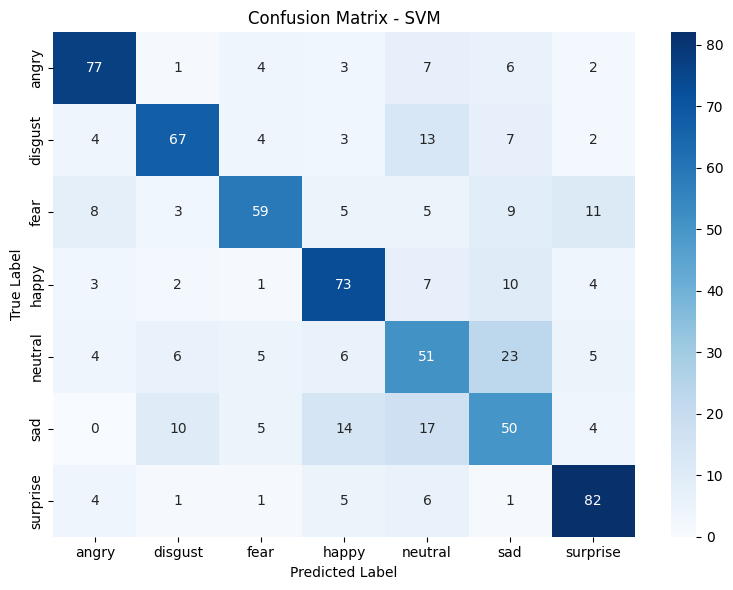

Accuracy: 65.57%


In [46]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

### **4.3. Predict Another Images**

Setelah memperoleh hasil evaluasi dari model, coba terapkan model untuk memprediksi citra lain di luar _dataset_.

In [31]:
def predict_image(img_path):
    # Load and show the original image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return None
    
    # Display original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    # Preprocessing - make sure this matches EXACTLY what was done in training
    preprocessed_img = preprocess_image(img)
    
    # Debugging: Display the preprocessed image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB) if len(preprocessed_img.shape) == 3 else preprocessed_img, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()
    
    # Extract features with additional debugging
    print("Extracting features...")
    canny_features = canny_feature_extractor.extract_features(preprocessed_img)
    print(f"Canny features shape: {canny_features.shape}, range: {canny_features.min()}-{canny_features.max()}")
    
    glcm_features_list = glcm_feature_extractor.extract_features(preprocessed_img)
    glcm_features = []
    for glcm_dict in glcm_features_list:
        glcm_features.extend(list(glcm_dict.values()))
    glcm_features = np.array(glcm_features)
    print(f"GLCM features shape: {glcm_features.shape}, range: {glcm_features.min()}-{glcm_features.max()}")
    
    # Combine features
    features = np.concatenate([canny_features, glcm_features])
    print(f"Combined features shape: {features.shape}")
    
    # Reshape and scale - ensure scaler is properly fitted
    features = features.reshape(1, -1)
    print(f"Before scaling - features range: {features.min()}-{features.max()}")
    
    try:
        features = scaler.transform(features)
        print(f"After scaling - features range: {features.min()}-{features.max()}")
    except Exception as e:
        print(f"Error during scaling: {e}")
        return None
    
    # Get probabilities, not just class prediction
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(features)
        class_probabilities = dict(zip(label_encoder.classes_, probabilities[0]))
        print("\nClass probabilities:")
        for cls, prob in sorted(class_probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"{cls}: {prob:.4f}")
    
    # Make prediction
    prediction = best_model.predict(features)
    class_name = label_encoder.inverse_transform(prediction)
    
    # Display result
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {class_name[0]}")
    plt.axis('off')
    plt.show()
    
    return class_name[0]

Testing emotion recognition on sample images:

Actual emotion: angry
Image: angry.jpg


<Figure size 1500x1200 with 0 Axes>

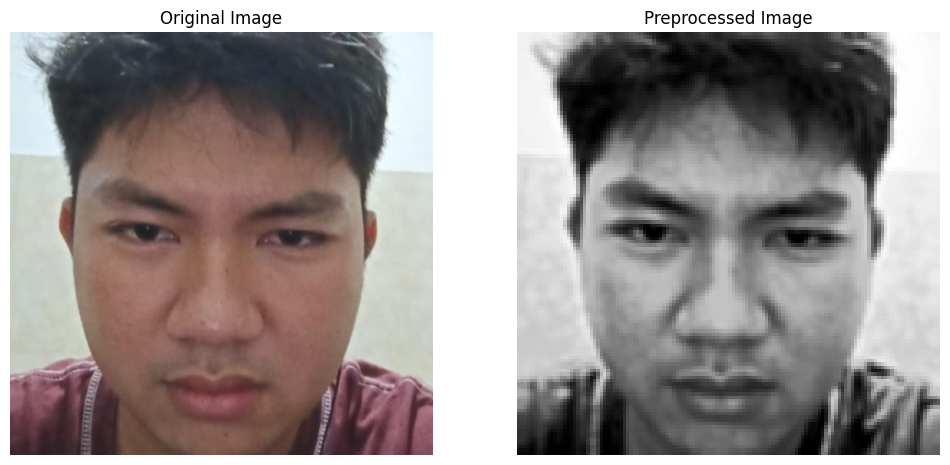

Extracting features...
Canny features shape: (192,), range: 0.0-128.0
GLCM features shape: (24,), range: 0.07043872773647308-4.259262561798096
Combined features shape: (216,)
Before scaling - features range: 0.0-128.0
After scaling - features range: -1.5278995505446353-4.380577200311472

Class probabilities:
angry: 0.1975
fear: 0.1839
disgust: 0.1693
neutral: 0.1257
happy: 0.1142
sad: 0.1110
surprise: 0.0984


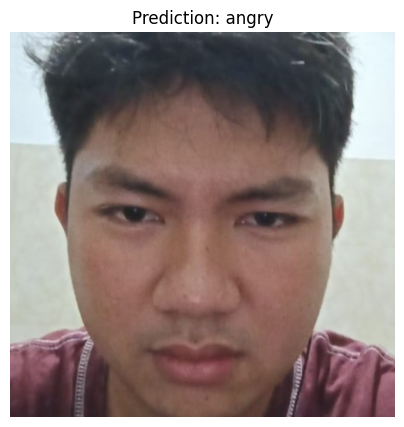

Predicted emotion: angry
Result: ✓ Correct

Actual emotion: disgust
Image: disgust.jpg


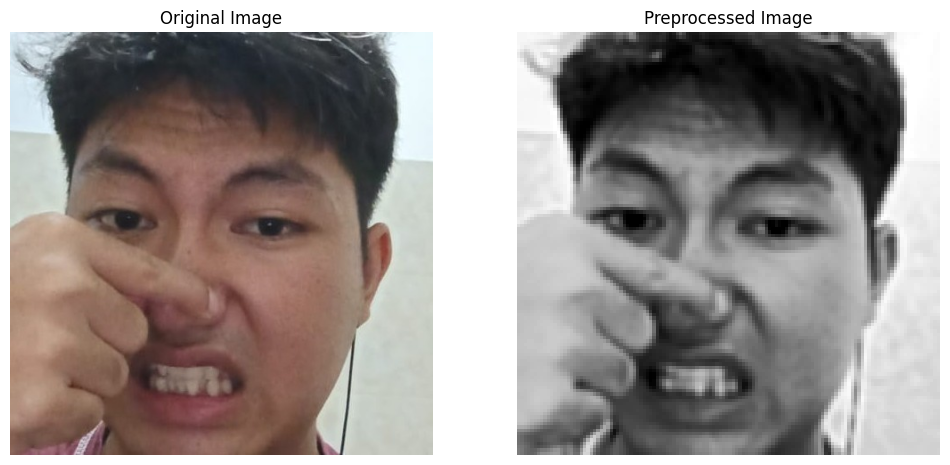

Extracting features...
Canny features shape: (192,), range: 0.0-94.0
GLCM features shape: (24,), range: 0.0709734708070755-4.2385125160217285
Combined features shape: (216,)
Before scaling - features range: 0.0-94.0
After scaling - features range: -1.8950494203533017-7.244965904979235

Class probabilities:
disgust: 0.1746
angry: 0.1448
fear: 0.1437
surprise: 0.1431
neutral: 0.1329
sad: 0.1313
happy: 0.1295


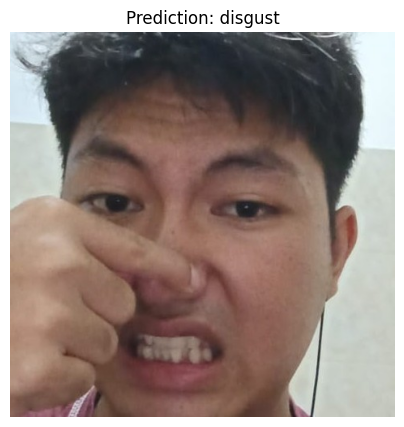

Predicted emotion: disgust
Result: ✓ Correct

Actual emotion: fear
Image: fear.jpg


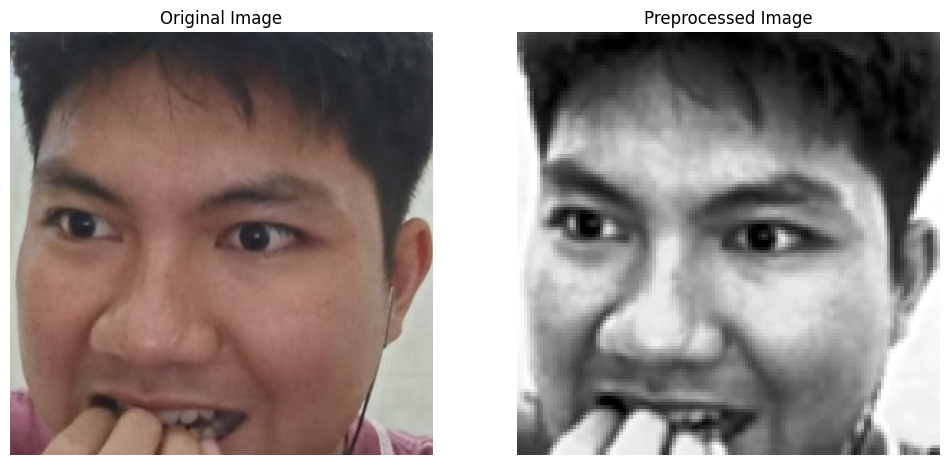

Extracting features...
Canny features shape: (192,), range: 0.0-67.0
GLCM features shape: (24,), range: 0.06739167124032974-4.297634124755859
Combined features shape: (216,)
Before scaling - features range: 0.0-67.0
After scaling - features range: -1.5903566574662136-5.546572463726541

Class probabilities:
fear: 0.1696
disgust: 0.1550
neutral: 0.1444
sad: 0.1439
happy: 0.1389
surprise: 0.1326
angry: 0.1156


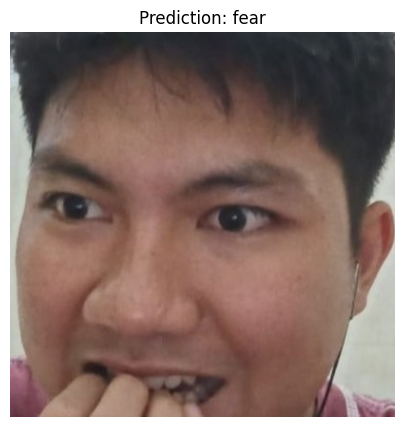

Predicted emotion: fear
Result: ✓ Correct

Actual emotion: happy
Image: happy.jpg


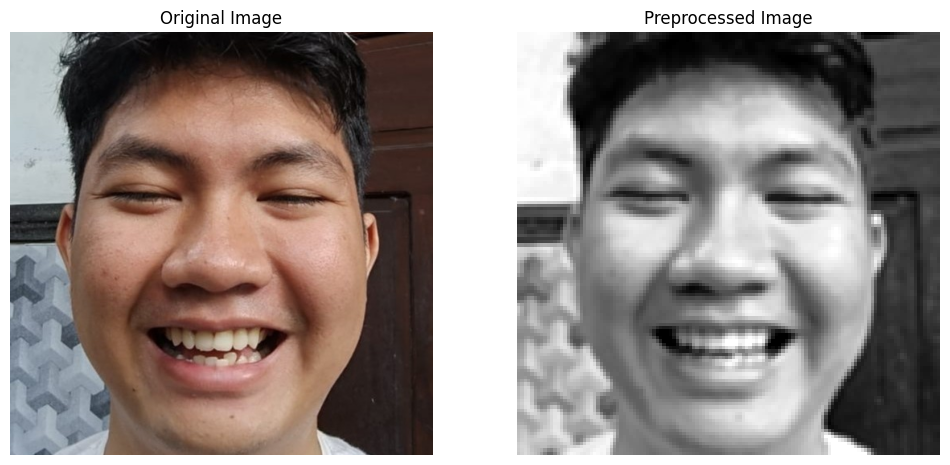

Extracting features...
Canny features shape: (192,), range: 0.0-162.0
GLCM features shape: (24,), range: 0.06189676374197006-4.418961524963379
Combined features shape: (216,)
Before scaling - features range: 0.0-162.0
After scaling - features range: -1.5618895567782882-5.195539345608973

Class probabilities:
happy: 0.2572
disgust: 0.1575
neutral: 0.1508
sad: 0.1442
angry: 0.1065
fear: 0.1020
surprise: 0.0818


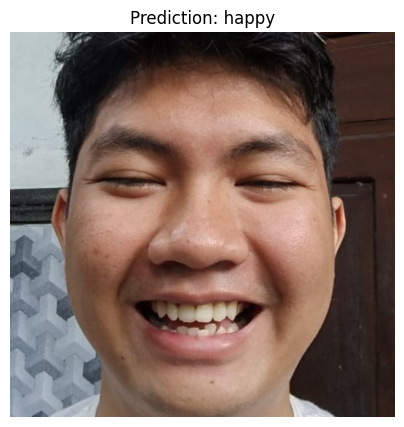

Predicted emotion: happy
Result: ✓ Correct

Actual emotion: neutral
Image: neutral.jpg


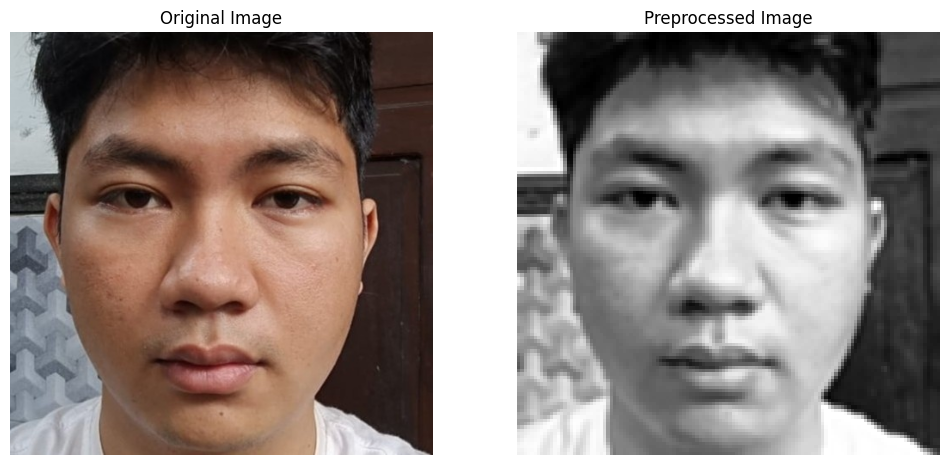

Extracting features...
Canny features shape: (192,), range: 0.0-85.0
GLCM features shape: (24,), range: 0.06613623350858688-4.334791660308838
Combined features shape: (216,)
Before scaling - features range: 0.0-85.0
After scaling - features range: -1.7516766160820187-7.0652725250874875

Class probabilities:
neutral: 0.2938
disgust: 0.1635
sad: 0.1245
angry: 0.1181
fear: 0.1158
surprise: 0.0968
happy: 0.0874


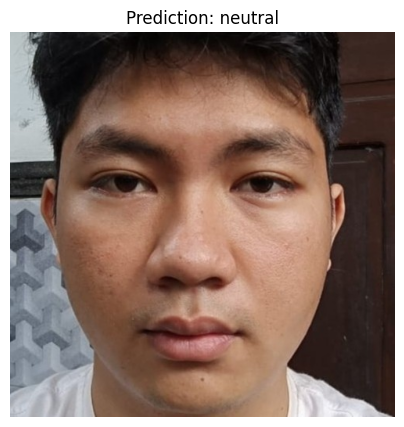

Predicted emotion: neutral
Result: ✓ Correct

Actual emotion: sad
Image: sad.jpg


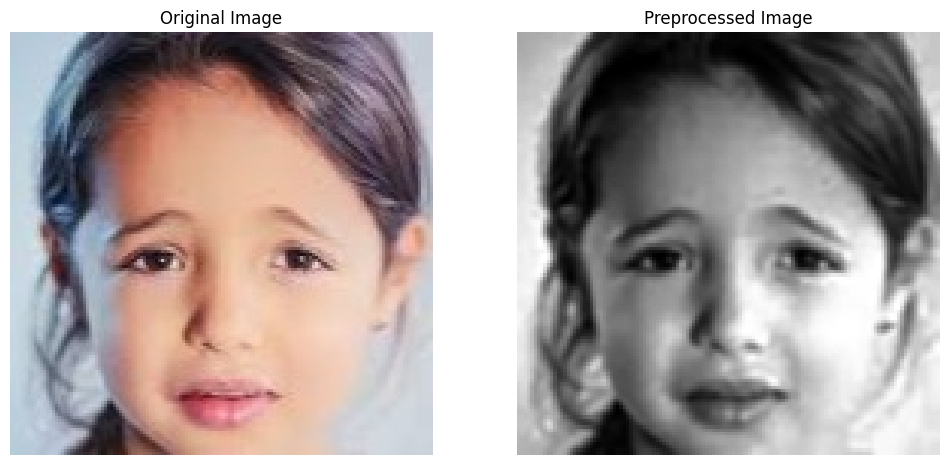

Extracting features...
Canny features shape: (192,), range: 0.0-61.0
GLCM features shape: (24,), range: 0.06961455941200256-4.220797538757324
Combined features shape: (216,)
Before scaling - features range: 0.0-61.0
After scaling - features range: -2.15915765192419-5.508035564759735

Class probabilities:
sad: 0.1993
fear: 0.1650
happy: 0.1533
neutral: 0.1377
surprise: 0.1267
disgust: 0.1211
angry: 0.0970


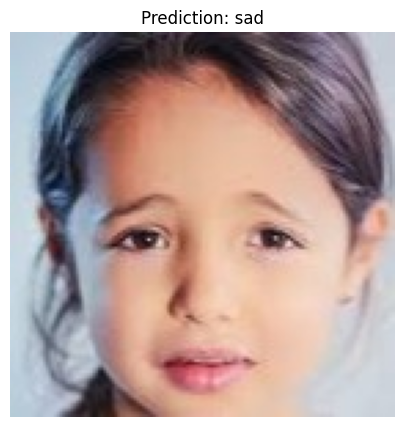

Predicted emotion: sad
Result: ✓ Correct

Actual emotion: surprise
Image: surprise.jpg


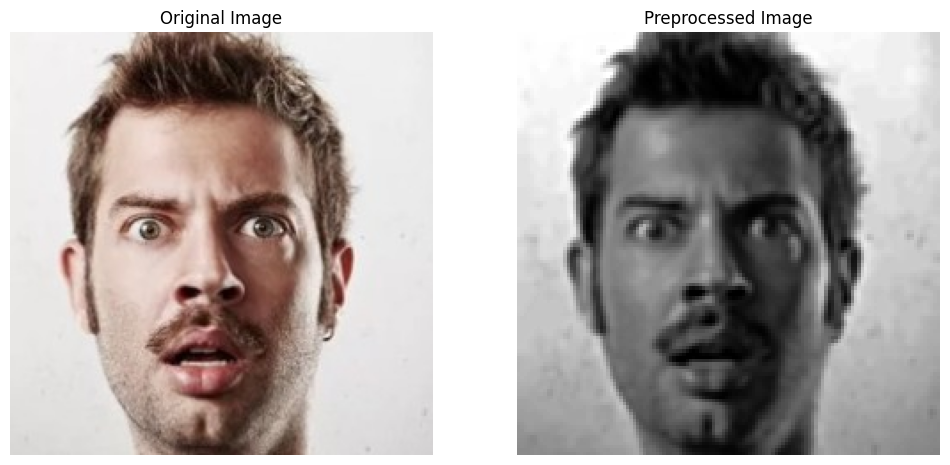

Extracting features...
Canny features shape: (192,), range: 0.0-74.0
GLCM features shape: (24,), range: 0.07809233665466309-4.0837554931640625
Combined features shape: (216,)
Before scaling - features range: 0.0-74.0
After scaling - features range: -1.99758506045119-3.886381979902122

Class probabilities:
surprise: 0.2368
fear: 0.1555
angry: 0.1480
sad: 0.1269
disgust: 0.1190
neutral: 0.1113
happy: 0.1025


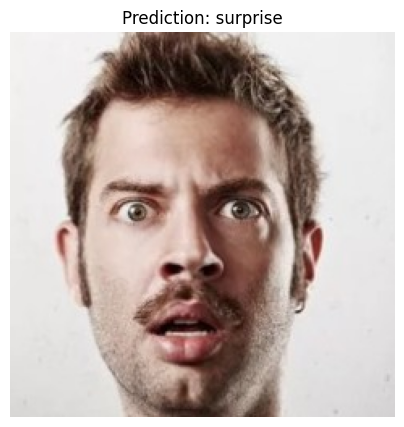

Predicted emotion: surprise
Result: ✓ Correct


In [32]:
predict_path = os.path.join(base_path, "predict")
predict_path = os.path.join(predict_path, "test")
plt.figure(figsize=(15, 12))

print("Testing emotion recognition on sample images:")
for image_name in os.listdir(predict_path):
    # Dapatkan informasi citra
    image_path = os.path.join(predict_path, image_name)
    true_emotion = image_name[:-4]
    print(f"\nActual emotion: {true_emotion}")
    print(f"Image: {image_name}")
    
    # Prediksi dan tampilkan gambar dengan prediksi
    prediction = predict_image(image_path)
    print(f"Predicted emotion: {prediction}")
    result = "✓ Correct" if prediction == true_emotion else f"✗ Incorrect (actual: {true_emotion})"
    print(f"Result: {result}")
    print("=" * 50)

# **5. Export Model**

Setelah seluruh tahapan selesai, tahap terakhir adalah ekspor model agar dapat diimplementasikan ke dalam _software_.

In [57]:
if not hasattr(SVM_Scratch, 'save_model'):
    def save_model(self, filename):
        """Menyimpan model SVM yang sudah dilatih ke dalam file."""
        model_data = {
            'kernel_type': self.kernel_type,
            'C': self.C,
            'degree': self.degree,
            'gamma': self.gamma,
            'coef0': self.coef0,
            'alphas': self.alphas,
            'support_vectors': self.support_vectors,
            'support_vector_labels': self.support_vector_labels,
            'b': self.b,
            'is_multiclass': self.is_multiclass,
            'classes': self.classes if hasattr(self, 'classes') else None
        }
        
        # Jika model multiclass, simpan semua submodel
        if self.is_multiclass:
            # Create a helper function inside to avoid scoping issues
            def save_model_dict(model):
                return {
                    'kernel_type': model.kernel_type,
                    'C': model.C,
                    'degree': model.degree,
                    'gamma': model.gamma,
                    'coef0': model.coef0,
                    'alphas': model.alphas,
                    'support_vectors': model.support_vectors,
                    'support_vector_labels': model.support_vector_labels,
                    'b': model.b,
                    'is_multiclass': model.is_multiclass
                }
            
            model_data['models'] = {cls: save_model_dict(model) for cls, model in self.models.items()}
        
        # Simpan model ke file menggunakan pickle
        with open(filename, 'wb') as file:
            pickle.dump(model_data, file)
        
        print(f"Model berhasil disimpan ke {filename}")
    
    # Add the method to the class
    SVM_Scratch.save_model = save_model

In [61]:
model.fit(X_train, y_train)
model.save_model("svm_model.pkl")

Training 7 OvR SVM models...



OvR SVM Training: 100%|██████████| 7/7 [08:53<00:00, 76.15s/it]


AttributeError: 'SVM_Scratch' object has no attribute 'save_model'